## Inference

In [1]:
from tensorflow.keras.saving import load_model
from yolo_loss import YoloLoss
from yolo_preprocessing import *
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
import matplotlib.pyplot as plt

2026-02-11 21:41:45.689756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model = load_model('model_trained/model.keras')

PATH_DATASET_TRAIN = "./PASCALVOC2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations/"

files = [os.path.join(PATH_DATASET_TRAIN, f) for f in sorted(os.listdir(PATH_DATASET_TRAIN)) if f.endswith(".xml")]
train_files, valid_files = train_test_split(files, test_size=0.2, random_state=42, shuffle=True)

# Removing classes head, hand, foot like in orginal paper
class_names = ["person", "bird", "cat", "cow", "dog", "horse", "sheep", "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train", "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor", "head", "foot", "hand"]
remove_these_vals = ['head', 'hand', 'foot']

img_size = (350, 350)
S, B, C = 7, 2, 20

I0000 00:00:1770842514.456018  143047 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13372 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
2026-02-11 21:42:27.834310: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1677721600 exceeds 10% of free system memory.
2026-02-11 21:42:30.762487: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1677721600 exceeds 10% of free system memory.
2026-02-11 21:42:33.351586: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1677721600 exceeds 10% of free system memory.


In [3]:
score_treshold = 0.25
def plot_img_and_bbox(X, y_gt, y_pred_boxes=False, y_pred_scores=False, y_pred_classes=False, n_images=1, figsize=(10, 10), img_size=img_size, score_threshold=score_treshold):
    fig, ax = plt.subplots(n_images, 2, figsize=(figsize[0], figsize[1] * n_images))

    ax[0, 0].set_title('Ground truth')
    ax[0, 1].set_title('Preds')

    if n_images == 1:
        ax = np.array([ax])

    for i in range(n_images):
        ax[i, 0].imshow(X[i])
        ax[i, 1].imshow(X[i])

        # True boxes and labels
        for j in range(len(y_gt[i])):
            # Bboxes
            box_1 = np.array(y_gt[i][j])
            x, y, w, h = box_1[0], box_1[1], box_1[2], box_1[3]
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none', label='true')
            ax[i, 0].add_patch(rect)

            # Labels and confs
            conf, label = box_1[4], box_1[5]
            label_text = class_names[int(label)]
            ax[i, 0].text(x, y -5, f'{label_text} ({conf:.2f})', color='black', fontsize=9, backgroundcolor='white')
            ax[i, 0].axis('off')

        # Pred boxes and labels
        for j in range(y_pred_boxes[i].shape[0]):
            ymin, xmin, ymax, xmax = y_pred_boxes[i][j]

            xmin *= img_size[1]
            xmax *= img_size[1]
            ymin *= img_size[0]
            ymax *= img_size[0]

            w_2 = xmax - xmin 
            h_2 = ymax - ymin

            rect = patches.Rectangle((xmin, ymin), w_2, h_2, linewidth=2, edgecolor='blue', facecolor='none')
            ax[i, 1].add_patch(rect)

            label = int(y_pred_classes[i][j])
            score = float(y_pred_scores[i][j])

            if score < score_threshold:
                continue

            label_text = class_names[label]

            ax[i, 1].text(xmin, ymin - 5, f"{label_text} ({score:.2f})", color='black', fontsize=9, backgroundcolor='white')

        ax[i, 1].axis('off')

    plt.tight_layout(pad=0.1)
    plt.subplots_adjust(wspace=0.02, hspace=0.02, top=0.59, bottom=0.01)
    plt.show()

## Validation set

In [4]:
X_valid, y_boxes_valid, y_labels_valid = new_load_dataset(valid_files, remove_these_vals, image_target_size=img_size)
X_valid = preprocess_input(np.array(X_valid))

y_boxes_valid_normalized = xywh_pixels_to_normalized_centers_per_image(y_boxes_valid, img_size)
y_valid_labels_onehot = to_one_hot(y_labels_valid, class_names)
y_valid_encoded = encode_batch(y_boxes_valid_normalized, y_valid_labels_onehot, S=S, B=B, C=C)
loss = model.evaluate(X_valid, y_valid_encoded)

print(f"Loss for validation set: {loss:.4f}")

2026-02-11 21:42:43.180762: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1474410000 exceeds 10% of free system memory.
2026-02-11 21:42:44.320573: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1474410000 exceeds 10% of free system memory.
2026-02-11 21:42:45.656078: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ef608002f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-11 21:42:45.656110: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2026-02-11 21:42:45.770490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-11 21:42:46.053198: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2026-02-11 21:42:47.389822: I extern

 1/32 ━━━━━━━━━━━━━━━━━━━━ 5:47 11s/step - loss: 3.9893

I0000 00:00:1770842576.377887  143081 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 4.0539

2026-02-11 21:43:02.362910: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-02-11 21:43:02.922780: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-02-11 21:43:03.435606: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 269ms/step - loss: 4.0251
Loss for validation set: 4.0251


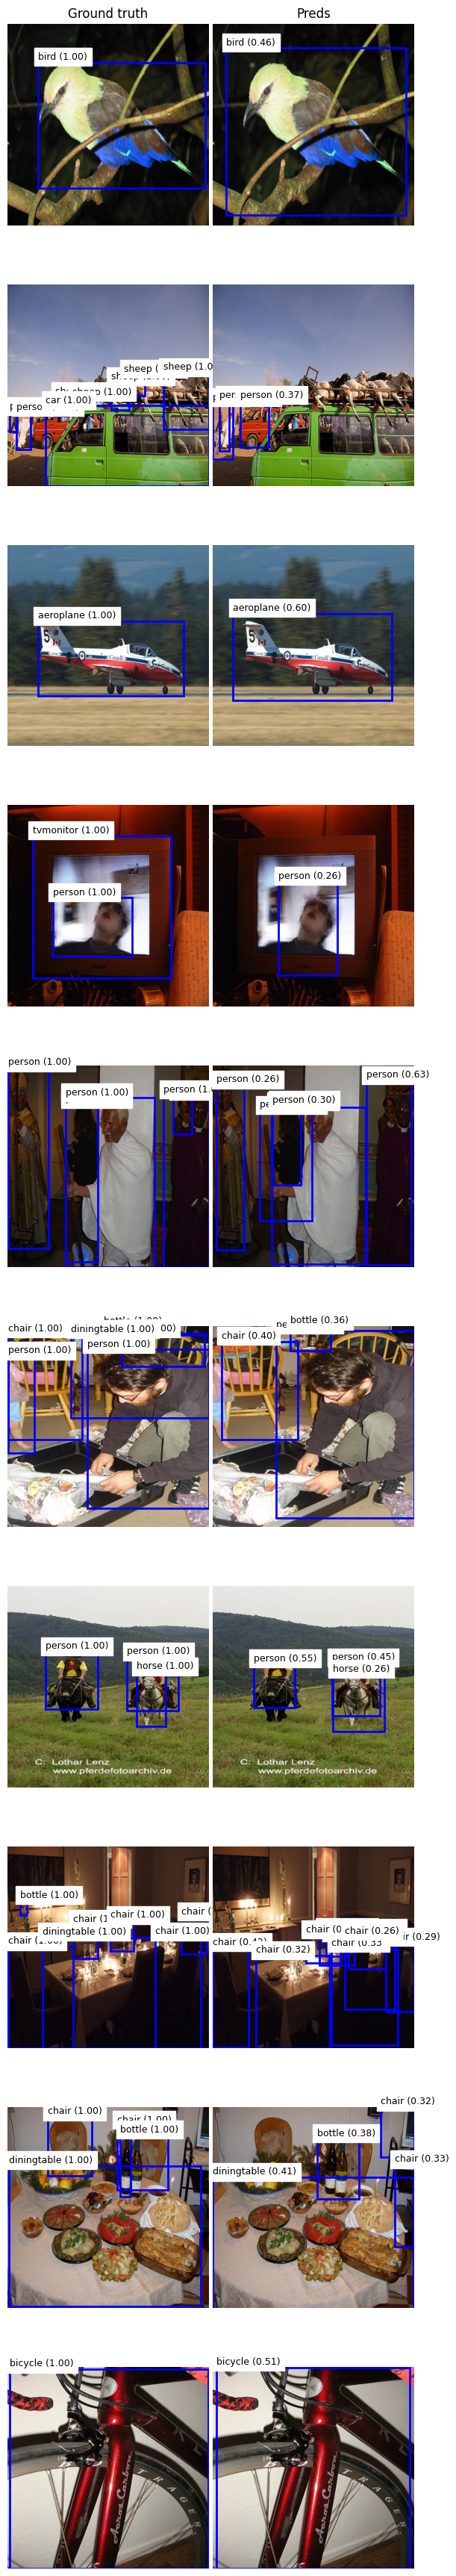

In [5]:
y_valid_decoded = decode_batch(y_valid_encoded, S, B, img_size, conf_thresh=1)
n_images_to_plot = 10
y_pred = model(X_valid[:n_images_to_plot], training=False).numpy()
X_valid = reverse_vgg16(X_valid)
y_pred_valid_bboxes, y_pred_valid_scores, y_pred_valid_classes, _ = nms(y_pred, S=S, B=B, C=C, iou_thrshold=0.5, score_threshold=score_treshold)

plot_img_and_bbox(X_valid, 
                 y_valid_decoded, 
                 y_pred_boxes=y_pred_valid_bboxes, 
                 y_pred_scores=y_pred_valid_scores, 
                 y_pred_classes=y_pred_valid_classes, 
                 n_images=n_images_to_plot, 
                 figsize=(6, 6))

## Test Set

In [6]:
PATH_DATASET_TEST = "./PASCALVOC2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/Annotations/"

test_files = [os.path.join(PATH_DATASET_TEST, f) for f in sorted(os.listdir(PATH_DATASET_TEST)) if f.endswith(".xml")]

X_test, y_boxes_test, y_labels_test = new_load_dataset(test_files[:1000], remove_these_vals, image_target_size=img_size)
X_test = preprocess_input(np.array(X_test))

y_boxes_test_normalized = xywh_pixels_to_normalized_centers_per_image(y_boxes_test, img_size)
y_test_labels_onehot = to_one_hot(y_labels_test, class_names)
y_test_encoded = encode_batch(y_boxes_test_normalized, y_test_labels_onehot, S=S, B=B, C=C)
loss = model.evaluate(X_test, y_test_encoded, batch_size=1)

print(f"Loss for test set: {loss:.4f}")

2026-02-11 21:43:26.460486: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-02-11 21:43:26.626640: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-02-11 21:43:26.736826: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 3.9501
Loss for test set: 3.9501


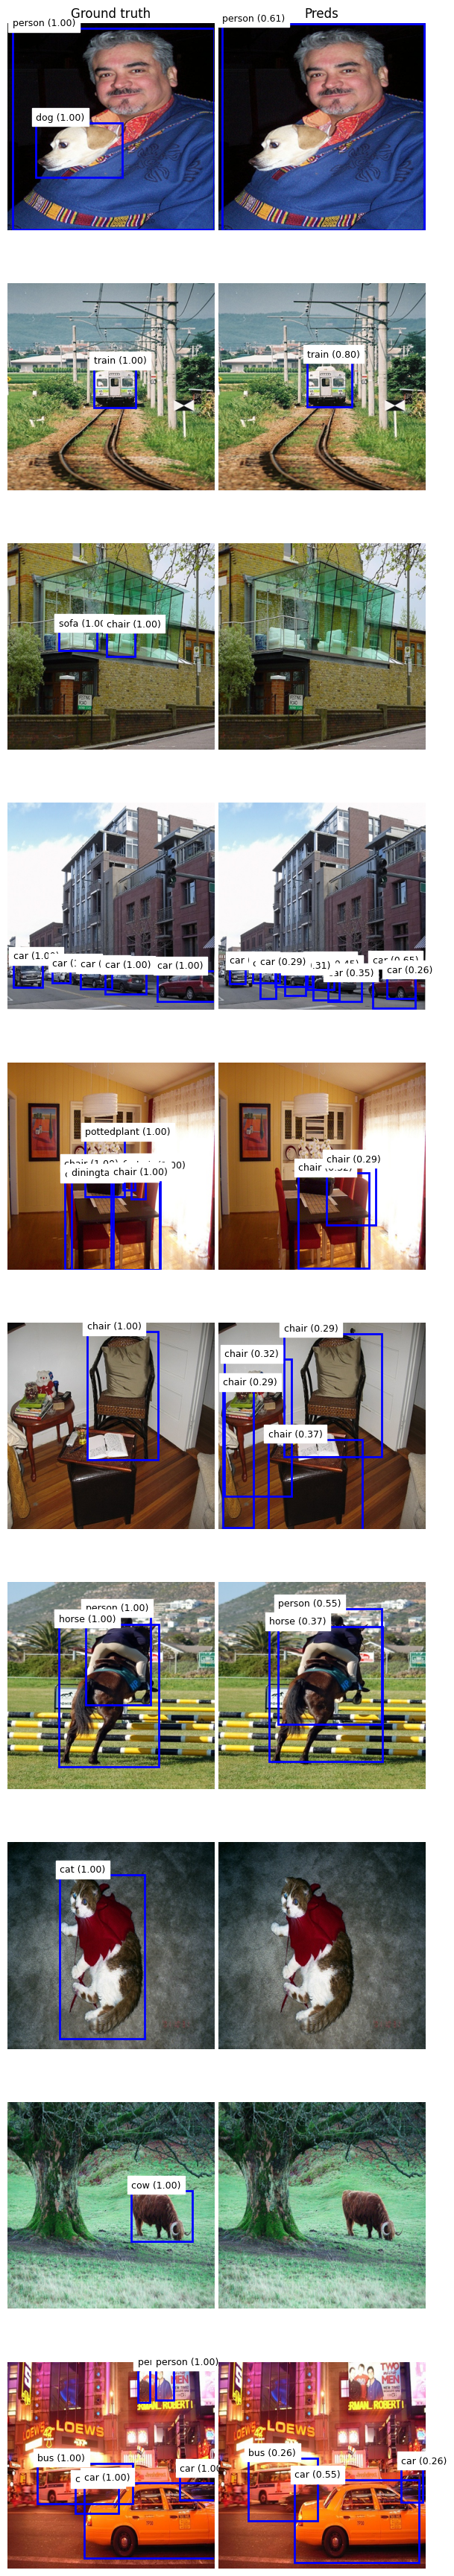

In [7]:
y_test_decoded = decode_batch(y_test_encoded, S, B, img_size, conf_thresh=1)
y_pred = model(X_test[:n_images_to_plot], training=False).numpy()
X_test = reverse_vgg16(X_test)
y_pred_test_bboxes, y_pred_test_scores, y_pred_test_classes, _ = nms(y_pred, S=S, B=B, C=C, iou_thrshold=0.5, score_threshold=score_treshold)

plot_img_and_bbox(X_test, 
                 y_test_decoded, 
                 y_pred_boxes=y_pred_test_bboxes, 
                 y_pred_scores=y_pred_test_scores, 
                 y_pred_classes=y_pred_test_classes, 
                 n_images=n_images_to_plot, 
                 figsize=(6, 6))